<a href="https://colab.research.google.com/github/Janith123gihan/Car-Damage-Classification/blob/main/Car_Damage_Classification_Transfer_Learning_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras import layers
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from keras.utils import plot_model

In [ ]:

print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.11.0
Found GPU at: /device:GPU:0


In [ ]:
def set_data(train,test, validation ,batchSize, image_size):
 
 Image_size = [image_size,image_size]

 train_datagen= ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,rescale=1./255,
                                   zoom_range=0.2,
                                   horizontal_flip=0.5, vertical_flip=0.5
                                   )

 test_datagen = ImageDataGenerator(rescale=1./255)

 val_datagen = ImageDataGenerator(rescale=1./255)

 #Training dataset
 train_set = train_datagen.flow_from_directory(
                train,
                target_size=Image_size,
                batch_size=batchSize, 
                color_mode="rgb",
                #shuffle=True,             
                interpolation='bicubic',
                class_mode='categorical'
                )
 #Testing dataset
 test_set= test_datagen.flow_from_directory(
              test,
              target_size=Image_size,
              color_mode = "rgb", interpolation='bicubic',
              class_mode='categorical', shuffle=False
             )
 validation_set = val_datagen.flow_from_directory(
    validation, # same directory as training data
    target_size=Image_size,
    color_mode = "rgb",interpolation='bicubic',
    batch_size=batchSize)
 return train_set, test_set, validation_set;

In [ ]:
def unfreeze_model(model, num_of_layers):
    for layer in model.layers[num_of_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

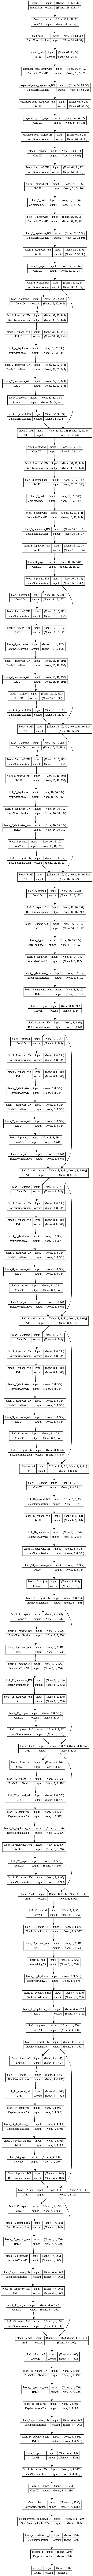

In [ ]:
from keras.layers.pooling.global_average_pooling2d import GlobalAveragePooling2D
from keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model



base_model = MobileNetV2(weights='imagenet',input_shape=(128,128,3), include_top=False)

head_model = Model(base_model.input, base_model.layers[-2].output) #last two layers are removed
head_model.trainable = False # Freeze the base model layers to prevent overfitting
head_model = unfreeze_model(head_model,-3)  



# Add a global average pooling layer and a dense layer on top of the base model
x = head_model.output
x = GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Add a final dense layer with 3 units for the 3 classes
predictions = Dense(3, activation='softmax')(x)

# Create a new model using the base model and the added layers
model = Model(inputs=head_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


plot_model(model,show_shapes=True, show_layer_names=True)

In [ ]:
def plot_hist(hist):
    plt.figure(3)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
    plt.figure(4)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

batchSize = 32
epoches =120;
image_size = 224;
train_path = '/content/drive/MyDrive/Car Damage Classification/training'
test_path = '/content/drive/MyDrive/Car Damage Classification/testing'
validation_path = '/content/drive/MyDrive/Car Damage Classification/validation'

# checkpoint_path = "/content/drive/MyDrive/Car Damage Classification/vgg16/checkpoint.hdf5"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                   monitor='val_categorical_accuracy',mode='max',
#                                                 save_best_only=True,
#                                                 verbose=1)



train_set, test_set, validation_set = set_data(train_path,test_path,validation_path, batchSize, image_size)

history=model.fit(train_set,  validation_data= validation_set,epochs = epoches, shuffle=True)
plot_hist(history)


In [ ]:
model.save('CNN-Car_Damage_Classification.h5')

# Testing Model

In [ ]:

model.save('/content/drive/MyDrive/Car Damage Classification/my_model')
results = model.evaluate(test_set,batch_size=32)
accuracy = results[1]
predict_labels=model.predict(test_set,batch_size=batchSize)
test_labels=test_set.classes
print(accuracy)


In [ ]:
print(test_labels)
print(predict_labels.argmax(axis=1))
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_labels, predict_labels.argmax(axis=1), target_names=['minor', 'moderate', 'severe']))
confusion = confusion_matrix(test_labels, predict_labels.argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)
